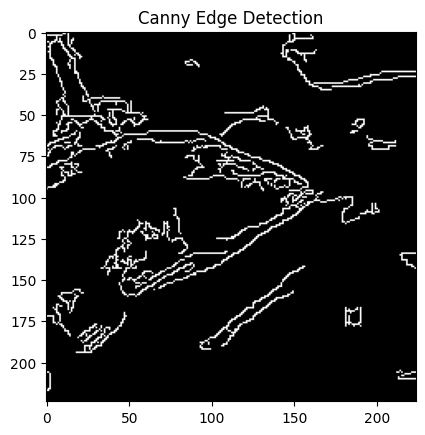

Hough features (number of lines detected): [0, 2, 0, 1, 186, 3, 0, 1, 0, 1, 20, 5, 2, 13, 0, 0, 11, 34, 139, 26, 0, 55, 5, 28, 23, 17, 0, 0, 0, 1, 0, 2, 19, 15, 0, 1, 0, 0, 423, 0, 0, 4, 0, 0, 516, 0, 7, 143, 258, 0, 1, 0, 2, 55, 2, 0, 2, 833, 0, 18, 0, 71, 20, 1, 22, 126, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 275, 433, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1183, 0, 1, 7, 1, 836, 1, 0, 44, 102, 0, 14, 0, 2, 3, 35, 3, 1, 2, 4, 0, 1080, 3, 41, 0, 485, 5, 0, 45, 1339, 497, 0, 0, 3, 2, 0, 5, 623, 0, 0, 3, 7, 98, 6, 18, 368, 1012, 9, 1, 2, 1, 1, 0, 43, 2, 0, 685, 97, 0, 9, 55, 953, 0, 0, 6, 5, 0, 176, 123, 5, 0, 1, 6, 6, 6, 122, 75, 0, 0, 0, 9, 579, 0, 40, 1, 0, 10, 0, 0, 228, 510, 442, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 

C:\Users\KIIT\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Random Forest Classifier
Classification Accuracy: 0.8742857142857143
Precision: 0.8628571428571429
Recall: 0.8742857142857143
F1 Score: 0.8674423963133641
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.40      0.45        45
           1       0.91      0.94      0.93       305

    accuracy                           0.87       350
   macro avg       0.71      0.67      0.69       350
weighted avg       0.86      0.87      0.87       350

LBP feature importances: 0.07
LDP feature importances: 0.01
BWT feature importances: 0.91
Hough feature importances: 0.01


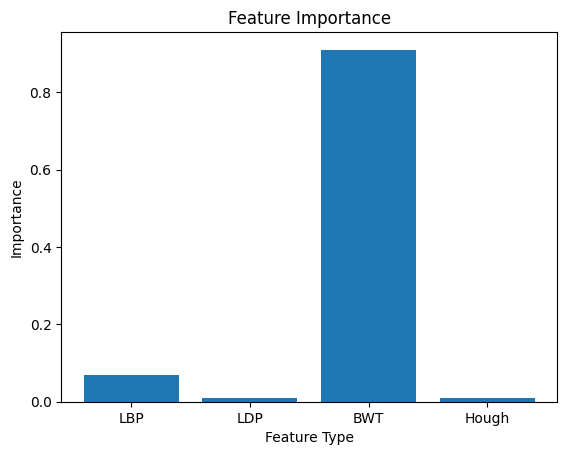

In [12]:
import os
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Function to load images and labels from a dataset folder
def load_dataset(dataset_path):
    images = []
    labels = []
    label_names = os.listdir(dataset_path)
    for label in label_names:
        label_path = os.path.join(dataset_path, label)
        for image_name in os.listdir(label_path):
            image_path = os.path.join(label_path, image_name)
            image = cv2.imread(image_path)
            images.append(image)
            labels.append(label)
    return images, labels

# Apply LBP
def apply_lbp(image, num_points=24, radius=8):
    lbp = local_binary_pattern(image, num_points, radius, method='uniform')
    return lbp

# Apply LDP
def apply_ldp(image):
    gx = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=3)
    magnitude, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
    angle_bins = np.int32(8 * angle / 360)  # Quantize the angle to 8 bins
    return angle_bins

# Compute histogram
def compute_histogram(image, bins=16):
    hist, _ = np.histogram(image.ravel(), bins=bins, range=(0, bins))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # Normalize the histogram
    return hist

# Apply BWT (Block-wise Truncation)
def apply_bwt(image, blocks=(8, 8)):
    features = []
    h, w = image.shape
    (bx, by) = blocks
    xsteps = np.linspace(0, w, bx + 1, dtype=int)
    ysteps = np.linspace(0, h, by + 1, dtype=int)
    for i in range(1, len(ysteps)):
        for j in range(1, len(xsteps)):
            block = image[ysteps[i-1]:ysteps[i], xsteps[j-1]:xsteps[j]]
            hist = np.histogram(block, bins=256, range=(0, 256))[0] / (block.shape[0] * block.shape[1])
            features.extend(hist)
    return features

# Apply Hough Transform
def apply_hough(image):
    edges = cv2.Canny(image, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 100)  # Lowered the threshold to 100
    return len(lines) if lines is not None else 0

# Extract features from YCbCr channels
def extract_color_features(image):
    ycbcr_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    channels = cv2.split(ycbcr_image)
    features = []
    for channel in channels:
        lbp_image = apply_lbp(channel)
        lbp_hist_features = compute_histogram(lbp_image, bins=16)
        ldp_image = apply_ldp(channel)
        ldp_hist_features = compute_histogram(ldp_image, bins=16)
        features.extend(np.hstack((lbp_hist_features, ldp_hist_features)))
    return features

# Extract features from the dataset
def extract_features(images):
    lbp_features_list = []
    ldp_features_list = []
    bwt_features_list = []
    hough_features_list = []

    for image in images:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Apply LBP
        lbp_image = apply_lbp(gray_image)
        lbp_hist_features = compute_histogram(lbp_image, bins=16)
        lbp_features_list.append(lbp_hist_features)
        
        # Apply LDP
        ldp_image = apply_ldp(gray_image)
        ldp_hist_features = compute_histogram(ldp_image, bins=16)
        ldp_features_list.append(ldp_hist_features)
        
        # Apply BWT
        bwt_features = apply_bwt(gray_image)
        bwt_features_list.append(bwt_features)
        
        # Apply Hough Transform
        hough_features = apply_hough(gray_image)
        hough_features_list.append(hough_features)
    
    combined_features_list = [np.hstack((lbp, ldp, bwt, hough)) for lbp, ldp, bwt, hough in zip(lbp_features_list, ldp_features_list, bwt_features_list, hough_features_list)]
    return combined_features_list

# Load dataset
dataset_path = 'Fish_dt'  # Replace with your actual dataset path
images, labels = load_dataset(dataset_path)

# Check Edge Detection
sample_image = cv2.cvtColor(images[0], cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(sample_image, 50, 150, apertureSize=3)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Detection')
plt.show()

# Check Hough features again
hough_features = [apply_hough(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)) for image in images]
print("Hough features (number of lines detected):", hough_features)

# Convert labels to numerical values
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

# Extract features
features_list = extract_features(images)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_list, numeric_labels, test_size=0.2, random_state=42)

# Train the Random Forest model
clf = AdaBoostClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Random Forest Classifier")
print(f"Classification Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Get feature importances
feature_importances = clf.feature_importances_

# Print feature importances
num_lbp_features = len(compute_histogram(apply_lbp(cv2.cvtColor(images[0], cv2.COLOR_BGR2GRAY)), bins=16))
num_ldp_features = len(compute_histogram(apply_ldp(cv2.cvtColor(images[0], cv2.COLOR_BGR2GRAY)), bins=16))
num_bwt_features = len(apply_bwt(cv2.cvtColor(images[0], cv2.COLOR_BGR2GRAY)))
num_hough_features = 1

lbp_importances = feature_importances[:num_lbp_features]
ldp_importances = feature_importances[num_lbp_features:num_lbp_features+num_ldp_features]
bwt_importances = feature_importances[num_lbp_features+num_ldp_features:num_lbp_features+num_ldp_features+num_bwt_features]
hough_importances = feature_importances[-num_hough_features:]

print(f"LBP feature importances: {np.sum(lbp_importances)}")
print(f"LDP feature importances: {np.sum(ldp_importances)}")
print(f"BWT feature importances: {np.sum(bwt_importances)}")
print(f"Hough feature importances: {np.sum(hough_importances)}")

# Plot feature importances
importances = [np.sum(lbp_importances), np.sum(ldp_importances), np.sum(bwt_importances), np.sum(hough_importances)]
feature_names = ['LBP', 'LDP', 'BWT', 'Hough']

plt.bar(feature_names, importances)
plt.xlabel('Feature Type')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()